# Setup 

In [1]:
# setup random indicies
import numpy as np

np.random.seed(9)

house_ids = range(1,1461)
random_id = np.random.choice(house_ids, 1460, replace = False)


# load df
import pandas as pd
df = pd.read_csv("../data/train_model.csv")

# randomized index
df.drop(columns = ['Unnamed: 0', 'Id'], inplace = True)
df['random_id'] = random_id
df.set_index('random_id', inplace = True)
df.sort_index(inplace=True)
df.head(5)

# remove outliers
df.drop([907, 465], inplace=True)

# log transform SalePrice
df['SalePrice'] = np.log(df.SalePrice)

df.head(2)

,LotFrontage,LotArea,YearBuilt,GrLivArea,YrSold,SalePrice,MSZoning_RL,MSZoning_RMH,Alley_NoAccess,LotShape_Regular,...,OpenPorchSF_OpenPorch_Yes,Fence_no_fence,MoSold_peak_months,SaleType_non_deed,SaleCondition_not_normal,IsVinyl_yes,FullBaths_<=1FullBath,FullBaths_>=3FullBaths,HalfBaths_>=1HalfBaths,Enclosed_combined_EnclosedPorch_Yes
random_id,,,,,,,,,,,,,,,,,,,,,
1,87.0,9246,37,1656,2008,11.813030,1,0,1,0,...,1,1,0,0,0,0,0,0,0,0
2,60.0,7200,60,1904,2009,11.835009,1,0,1,1,...,0,0,1,0,0,1,0,0,1,1


In [2]:
#Import and prep test data
df_test_X = pd.read_csv("../data/test_model.csv")
df_test = df_test_X.copy()
df_test_ids = df_test.Id
df_test.drop(columns = ['Unnamed: 0', 'Id'], inplace = True)
df_test.head(2)

,LotFrontage,LotArea,YearBuilt,GrLivArea,YrSold,MSZoning_RL,MSZoning_RMH,Alley_NoAccess,LotShape_Regular,LandContour_Unflat,...,OpenPorchSF_OpenPorch_Yes,Fence_no_fence,MoSold_peak_months,SaleType_non_deed,SaleCondition_not_normal,IsVinyl_yes,FullBaths_<=1FullBath,FullBaths_>=3FullBaths,HalfBaths_>=1HalfBaths,Enclosed_combined_EnclosedPorch_Yes
0,80.0,11622,49,896,2010,0,1,1,1,0,...,0,0,1,0,0,1,1,0,0,1
1,81.0,14267,52,1329,2010,1,0,1,0,0,...,1,1,1,0,0,0,1,0,1,0


# Model 1: Saturated/Full
This model generates a coefficient for all features. We anticipate this to be an ovefit model but is a starting point to evaluate the efficacy of our feature engineering efforts.

In [3]:
from sklearn import linear_model
ols = linear_model.LinearRegression()

# Fit model using full training set
X_train = df.drop(['SalePrice'], axis = 1)
y_train = df.SalePrice

### Predicting SalePrice in test df using Saturated Linear Model

In [4]:
#fit and predict
ols.fit(X_train, y_train)
predict1 = np.exp(ols.predict(df_test)).round()

#ship for scoring
model_1_submission = pd.DataFrame({'Id' : df_test_ids,
                                   'SalePrice' : predict1})
model_1_submission
model_1_submission.to_csv("../predictions/model_1_submission.csv", index = False)
print("Model_1 printed!")

Model_1 printed!


### Kaggle result
RMSE: 0.13825  
Rank: 2081

# Model 2: Agressive Univariate (KBest, f_regressor) Feature Selection
First attempt at stepwise feature selection. There appeared to be 2 inflection points in the KBest iterative feature figure. Model 2 (agressively) seeks a parsimonious model by selecting for 28 features in these first 2 regions.

In [5]:
import sklearn.feature_selection as fs

#setup stepwise selection using KBest, f_regression
k28_features = fs.SelectKBest(fs.f_regression, k=28)
k28_features.fit(X_train, y_train)

#grab column indicies for best 28
idxs = k28_features.get_support(indices=True).tolist()
idxs = [0] + idxs # don't forget constant

### Predicting SalePrice in test df using Univarate Feature Selection

In [6]:
df_test.iloc[:,idxs].head(5)

,LotFrontage,LotFrontage,YearBuilt,GrLivArea,MSZoning_RMH,Neighborhood_NAmes,OverallQual_HighQ,OverallQual_LowQ,MasVnrType_no_masvnr,ExterQual_low,...,FireplaceQu_OthFireplace,GarageType_Detached,GarageFinish_GarageUnf,GarageCars_1.0,GarageCars_AtLeast3,GarageQual_GarageQual_not_good,GarageCond_GarageCond_not_good,OpenPorchSF_OpenPorch_Yes,FullBaths_<=1FullBath,FullBaths_>=3FullBaths
0,80.0,80.0,49,896,1,0,0,0,1,1,...,1,0,1,1,0,0,0,0,1,0
1,81.0,81.0,52,1329,0,0,0,0,0,1,...,1,0,1,1,0,0,0,1,1,0
2,74.0,74.0,13,1629,0,1,0,0,1,1,...,1,0,0,0,0,0,0,1,0,0
3,78.0,78.0,12,1604,0,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,43.0,43.0,18,1280,0,1,1,0,1,0,...,1,0,0,0,0,0,0,1,0,0


In [7]:
#fit and predict
ols.fit(X_train.iloc[:,idxs], y_train)

predict2 = np.exp(ols.predict(df_test.iloc[:,idxs])).round()

model_2_submission = pd.DataFrame({'Id' : df_test_ids,
                                  'SalePrice' : predict2})

#ship for scoring
model_2_submission.to_csv("../predictions/model_2_submission.csv", index = False)
print("Model_2 printed!")

Model_2 printed!


### Kaggle result
RMSE: 0.17350  
Rank: n/a, did not improve score

# Model 3: LM with Lasso Regularization
Based on the univariate model, lasso regularization will drop some number of features that reduces prediction bias.  
Model 2 indicated that 28 features was not a good stopping point (based on Kaggle result with holdout RMSE).  
How many features will remain after Lasso Regularization?

In [8]:
lasso = linear_model.Lasso(random_state=9,alpha=0.0011497569953977356)
lasso.fit(X_train, y_train)

Lasso(alpha=0.0011497569953977356, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=9, selection='cyclic', tol=0.0001, warm_start=False)

### Predicting SalePrice in test df using Lasso Regularization

In [9]:
predict3 = np.exp(lasso.predict(df_test)).round()
model_3_submission = pd.DataFrame({'Id': df_test_ids,"SalePrice": predict3})
model_3_submission.to_csv("../predictions/model_3_submission.csv", index = False)
print("Model_3 printed!")

Model_3 printed!


### Kaggle result
RMSE:  
Rank:  

# Model 4: LM with Ridge Regularization
Interestingly, lasso regularizaiton did not drop many features.  
This suggests that many, now few features significantly contribute to the model.  
Therefore, let's repeat the LM regularization process with L2.

In [10]:
ridge = linear_model.Lasso(random_state=9,alpha=59.94842503189412)
ridge.fit(X_train, y_train)

Lasso(alpha=59.94842503189412, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=9,
   selection='cyclic', tol=0.0001, warm_start=False)

In [11]:
predict4 = np.exp(lasso.predict(df_test)).round()
model_4_submission = pd.DataFrame({'Id': df_test_ids,"SalePrice": predict4})

In [12]:
model_4_submission.to_csv("../predictions/model_4_submission.csv", index = False)
print("Model_3 printed!")

Model_3 printed!


### Kaggle result
RMSE:  
Rank:  

# Model 5: Decision Tree
We have focused on finding a regression solution using a linear model.  
What about trees? (decision) Trees are the solution?

In [13]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}
grid_search_cv = GridSearchCV(DecisionTreeRegressor(random_state=42), params, n_jobs=-1, verbose=1)

# Fit model using full training set
X_train = df.drop(['SalePrice'], axis = 1)
y_train = df.SalePrice

model_5_fit = grid_search_cv.fit(X_train, y_train)
grid_search_cv.best_estimator_

Fitting 3 folds for each of 294 candidates, totalling 882 fits


[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 882 out of 882 | elapsed:    1.3s finished


DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=96, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=3, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

### Predicting SalePrice in test df using Decision Tree

In [14]:
#fit and predict
predict5 = np.exp(model_5_fit.predict(df_test)).round()

#ship for scoring
model_5_submission = pd.DataFrame({'Id': df_test_ids,"SalePrice": predict5})
model_5_submission.to_csv("../predictions/model_5_submission.csv", index = False)
print("Model_5 printed!")

Model_5 printed!


### Kaggle result
RMSE:  
Rank:  

# Model 6: Bagging predictions (simple ensemble)
Each model makes certain assumptions and errors.  
Averaging predictions discorrolates error, which may futher reduce bias.

In [30]:
#append predictive models
ensemble_model = pd.DataFrame({'Id' : df_test_ids,
                               'Model_1' : predict1
})
ensemble_model['Model_2'] = predict2
ensemble_model['Model_3'] = predict3
ensemble_model['Model_4'] = predict4
ensemble_model['Model_5'] = predict5

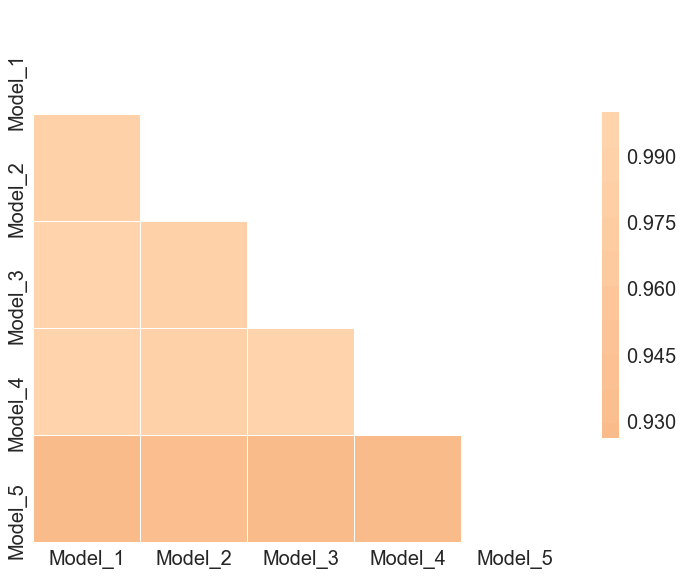

In [27]:
#evaluate correlation
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style = 'white', font_scale = 2)

corr_matrix = ensemble_model.iloc[:,1:].corr()
mask = np.zeros_like(corr_matrix, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(12,12))


sns.heatmap(corr_matrix, mask = mask, center = 0, 
           square = True, linewidths=.5, cbar_kws={'shrink': .5})

### Predicting SalePrice from an ensemble of predictive models

In [ ]:
# take average
#ensemble_model['SalePrice'] = ensemble_model.iloc[:,1:].mean(axis = 1)
# export csv
#ensemble_model.head(3)

### Kaggle result
RMSE:  
Rank: 